In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.io import loadmat
import os
%matplotlib inline

In [2]:
import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from time_shifted_PID import Histo3D2Dict
from time_shifted_PID import PIfunc
from time_shifted_PID import EqualState
from Spike_Generation import Spike_Time_Generater
from Spike_Generation import SG
from Spike_Generation import NL

importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from J_broja_PID.ipynb
importing Jupyter notebook from Spike_Generation.ipynb


In [3]:
plt.rcParams['figure.facecolor'] = 'white'
# plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams["font.size"] = 16
plt.rcParams["mathtext.fontset"] = "cm"

# load files RF

In [4]:
BS = loadmat('D:\\GoogleDrive\\retina\\oled_boundary_set', squeeze_me =True)

exp_folder = 'D:\\GoogleDrive\\retina\\Chou\'s data\\20210513\\'
direction = 'UD'

SVDnSTK = loadmat(exp_folder+'Analyzed_data\\30Hz_27_RF_15min_re\\unsort\\STK.mat'
                  , squeeze_me =True)
STK = SVDnSTK['gauss_RF']

RFprop  = loadmat(exp_folder+'Analyzed_data\\30Hz_27_RF_15min_re\\unsort\\RF_properties.mat'
                  , squeeze_me =True)
RFprop = RFprop['RF_properties']

In [5]:
def Gaussian_filter_2d_Rot(x, y, x0, y0, xs, ys, angle, A):
    cx = x[np.newaxis,:]*np.ones_like(y)[:,np.newaxis]  -x0
    cy = np.ones_like(x)[np.newaxis,:]*y[:,np.newaxis]-y0
    rx =  cx*np.cos(angle) - cy*np.sin(angle) 
    ry =  cx*np.sin(angle) + cy*np.cos(angle)
    return A*(np.exp(-((rx/xs)**2+(ry/ys)**2)/2)),  x-x0, y-y0

In [6]:
cn = 42
dt = 1/60.
micro_per_pixel = BS['micro_per_pixel']
RFellipse, xaxis, yaxis = Gaussian_filter_2d_Rot(
                                np.arange(1,801), np.arange(1,601), RFprop[cn-1]['X_Coor'], RFprop[cn-1]['Y_Coor'], 
                                RFprop[cn-1]['X_Width']/1.5/micro_per_pixel, RFprop[cn-1]['Y_Width']/1.5/micro_per_pixel,
                                RFprop[cn-1]['Angle'], RFprop[cn-1]['Amplitude'])

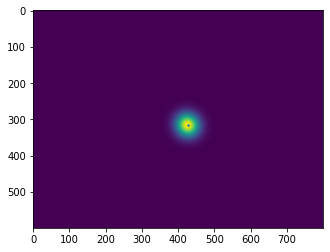

In [7]:
## SVD_SK on display area (whole OLED)
plt.imshow(RFellipse)
plt.scatter(RFprop[cn-1]['X_Coor']-1, RFprop[cn-1]['Y_Coor']-1, s=2)

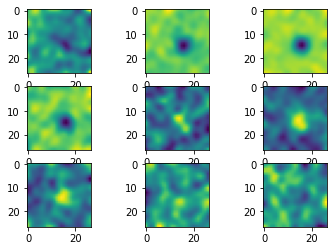

In [8]:
rSTK = STK[:,:,:,cn-1].reshape((STK.shape[0],-1))
U,sigma,VT=np.linalg.svd(rSTK)

fig, ax = plt.subplots(3,3)
for i in range(9):
    ax.flatten()[i].imshow(STK[i,:,:,cn-1])

# load files MB

In [9]:
files = ['merge_0727_OUsmooth_Bright_UD_G4.5_5min_Q100_6.5mW_0.5Hz',
         'merge_0727_OUsmooth_Bright_UD_G4.5_5min_Q100_6.5mW_1Hz',
         'merge_0727_OUsmooth_Bright_UD_G4.5_5min_Q100_6.5mW_2Hz',
         'merge_0727_OUsmooth_Bright_UD_G4.5_5min_Q100_6.5mW_4Hz']

Inten_list = []
rstate_list = []
T_list = []
x_list = []
for file in files:
    MBExp = loadmat(exp_folder+'merge\\'+file, squeeze_me =True)
    BarPos = MBExp['bin_pos']
    T=np.arange(len(BarPos)+1)*dt
    rstate, _ = np.histogram(MBExp['reconstruct_spikes'][cn-1], T)
    uBarPos, uI = np.unique(BarPos, return_inverse=True)
    if direction == 'UD':
        Inten = 6.5*np.array([np.sum(RFellipse[bp-400+300-BS['bar_wid']-1:bp-400+300+BS['bar_wid'],  ## 400 for pos center
                                               400-BS['bar_le']-1 : 400+BS['bar_le']])  for bp in uBarPos])
    Inten = Inten[uI]
    
    rstate_list.append( rstate.copy() )
    Inten_list.append( Inten.copy() )
    T_list.append( T.copy() )
    x = BarPos.copy()
    x = x.astype('float')
    x_list.append( x.copy() )

In [10]:
i = 0
BarPos = x_list[0].astype('int')
uBarPos, uI = np.unique(BarPos, return_inverse=True)
Inten = 6.5*np.array([np.sum(RFellipse[ (bp-400+300-BS['bar_wid']-1) : (bp-400+300+BS['bar_wid']),  ## 400 for pos center
                                       (400-BS['bar_le']-1) : (400+BS['bar_le']) ])  for bp in uBarPos])

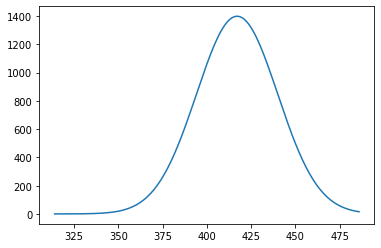

In [11]:
plt.plot(uBarPos, Inten)

(10000.0, 12000.0)

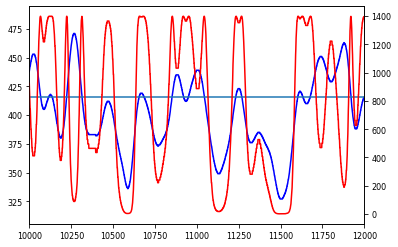

In [28]:
plt.plot(x_list[0], 'b')
plt.axhline(RFprop[cn-1]['Y_Coor']-1+100)
ax = plt.gca().twinx()
ax.plot(Inten_list[0], 'r')
plt.xlim([10000, 12000])

In [13]:
tv_list = [ ndimage.gaussian_filter1d(x, order=1, sigma=1)/dt  for x in x_list ]
#assign states
state_num = 6
xstate_list = [EqualState(x, state_num)[0] for x in x_list]
tvstate_list = [EqualState(tv, state_num)[0] for tv in tv_list]

# Real

## STA

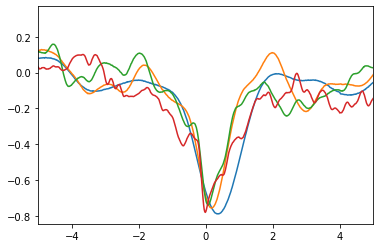

In [14]:
window = [-5,5] # second
timeaxis = np.arange(-500,501)*dt      
for i in range(len(Inten_list)):
    x = np.array(x_list[i])
    x = (x-np.mean(x))/np.std(x)

    Xcorr = np.correlate(x, rstate_list[i], 'same') / np.correlate(np.ones_like(x), rstate_list[i], 'same')
    Xcorr = Xcorr[int(len(Xcorr)/2)-500 : int(len(Xcorr)/2)+501]
    plt.plot(timeaxis,Xcorr)
    plt.xlim(window)

## MI

In [15]:
window = [-1,1] # second
Information_list = [0]*len(x_list)
for i in range(len(Inten_list)):
    timeshift, Information_list[i] = PIfunc(rstate_list[i], xstate_list[i], tvstate_list[i], dt, window)

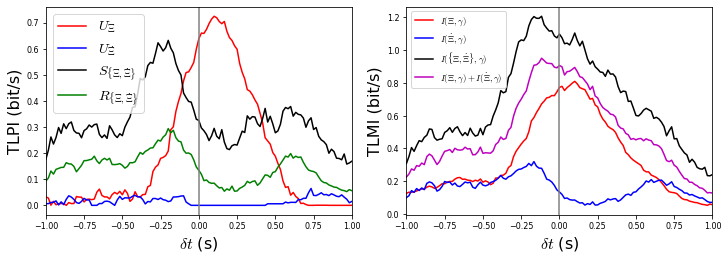

In [16]:
plt.rcParams["font.size"] = 8
i = 1
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
ax2.plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
ax2.plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
ax2.plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
ax2.plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
# ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_xlabel(r'$\delta t$ (s)', fontsize = 16)
ax2.set_ylabel('TLPI (bit/s)', fontsize = 16)
ax2.legend( (r'$U_\Xi$', r'$U_\dot\Xi$', r'$S_{\{\Xi,\dot\Xi\}}$', r'$R_{\{\Xi,\dot\Xi\}}$'), loc='best', prop={'size': 14})
ax2.axvline(0, c = 'gray')
ax2.set_xlim(window)

ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
ax3.plot(timeshift, Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]
                   +Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
# ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
ax3.set_xlabel(r'$\delta t$ (s)', fontsize = 16)
ax3.set_ylabel('TLMI (bit/s)', fontsize = 16)
ax3.axvline(0, c = 'gray')
ax3.set_xlim(window)
ax3.legend( (r'$I(\Xi,\gamma)$', r'$I(\dot\Xi,\gamma)$', r'$I(\{\Xi,\dot\Xi\},\gamma)$', r'$I(\Xi,\gamma)+I(\dot\Xi,\gamma)$'),
           loc='best', prop={'size': 9})


# fig.tight_layout(pad = 0, w_pad = 0.0, h_pad=0.0)
fig.set_size_inches(10, 3.5)

# Kernel response

## STA

In [17]:
STK_onOLED = np.zeros([STK.shape[0], 600, 800])
V1_onOLED = np.zeros([600, 800])
for i in range(267):
    for j in range(267):
        STK_onOLED[:,i+300-1-133, j+400-1-133] = STK[:, int(i/267*27), int(j/267*27), cn-1]
        V1_onOLED[i+300-1-133, j+400-1-133] = VT[0,:].reshape((27,27))[int(i/267*27), int(j/267*27)]

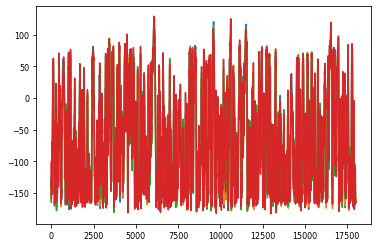

In [18]:
STKr_list = [0]*len(x_list)
for i in range(len(x_list)):
    BarPos = x_list[i].astype('int')
    r = np.zeros(len(BarPos))
    for k in range(len(BarPos)):
        for kk in np.arange(k-STK.shape[0]+1, k):
            bp = BarPos[kk]
            r[k] += np.sum(STK_onOLED[k-kk , bp-100-BS['bar_wid']-1:bp-100+BS['bar_wid'], 400-BS['bar_le']-1:400+BS['bar_le']])
    plt.plot(r)
    STKr_list[i] = r.copy()

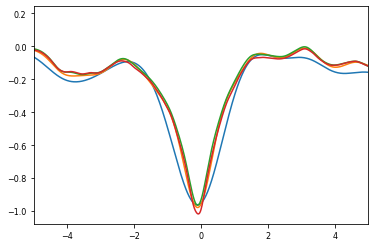

In [19]:
window = [-5,5] # second
timeaxis = np.arange(-500,501)*dt      
for i in range(len(Inten_list)):
    x = np.array(x_list[i])
    x = (x-np.mean(x))/np.std(x)

    r = STKr_list[i].copy()
    r = NL(r, np.mean(r))
    
    Xcorr = np.correlate(x, r, 'same') / np.correlate(np.ones_like(x), r, 'same')
    Xcorr = Xcorr[int(len(Xcorr)/2)-500 : int(len(Xcorr)/2)+501]
    plt.plot(timeaxis,Xcorr)
    plt.xlim(window)

## MI

In [20]:
STKrstate_list = [ SG(r, dt, 0, 2, 10) for r in STKr_list]

In [21]:
window = [-1,1] # second
STKInformation_list = [0]*len(x_list)
for i in range(len(Inten_list)):
    timeshift, STKInformation_list[i] = PIfunc(STKrstate_list[i], xstate_list[i], tvstate_list[i], dt, window)

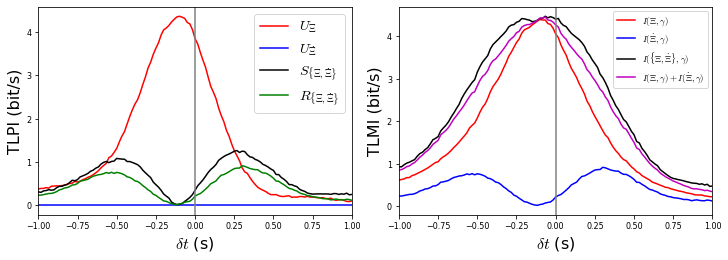

In [22]:
plt.rcParams["font.size"] = 8
i = 1
Information_list = STKInformation_list.copy()

fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
ax2.plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
ax2.plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
ax2.plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
ax2.plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
# ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_xlabel(r'$\delta t$ (s)', fontsize = 16)
ax2.set_ylabel('TLPI (bit/s)', fontsize = 16)
ax2.legend( (r'$U_\Xi$', r'$U_\dot\Xi$', r'$S_{\{\Xi,\dot\Xi\}}$', r'$R_{\{\Xi,\dot\Xi\}}$'), loc='best', prop={'size': 14})
ax2.axvline(0, c = 'gray')
ax2.set_xlim(window)

ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
ax3.plot(timeshift, Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]
                   +Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
# ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
ax3.set_xlabel(r'$\delta t$ (s)', fontsize = 16)
ax3.set_ylabel('TLMI (bit/s)', fontsize = 16)
ax3.axvline(0, c = 'gray')
ax3.set_xlim(window)
ax3.legend( (r'$I(\Xi,\gamma)$', r'$I(\dot\Xi,\gamma)$', r'$I(\{\Xi,\dot\Xi\},\gamma)$', r'$I(\Xi,\gamma)+I(\dot\Xi,\gamma)$'),
           loc='best', prop={'size': 9})


# fig.tight_layout(pad = 0, w_pad = 0.0, h_pad=0.0)
fig.set_size_inches(10, 3.5)

# SVD Kernel response

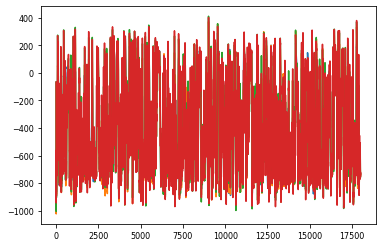

In [23]:
SVDSTKr_list = [0]*len(x_list)
for i in range(len(x_list)):
    BarPos = x_list[i].astype('int')
    r = np.zeros(len(BarPos))
    uBarPos, uI = np.unique(BarPos, return_inverse=True)
    SVDr = 6.5*np.array([np.sum(V1_onOLED[bp-100-BS['bar_wid']-1:bp-100+BS['bar_wid'],
                                      400-BS['bar_le']-1:400+BS['bar_le']])  for bp in uBarPos])
    SVDr = SVDr[uI]
    SVDr = np.convolve(SVDr, U[:,0], 'full')[:len(SVDr)]*sigma[0]
    
    plt.plot(SVDr)
    SVDSTKr_list[i] = SVDr.copy()

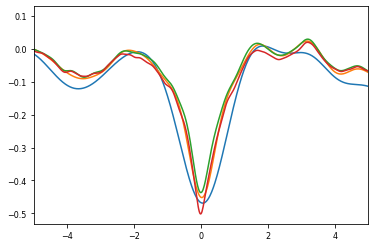

In [24]:
window = [-5,5] # second
timeaxis = np.arange(-500,501)*dt      
for i in range(len(Inten_list)):
    x = np.array(x_list[i])
    x = (x-np.mean(x))/np.std(x)

    r = SVDSTKr_list[i].copy()
    r = NL(r, np.mean(r)-np.std(r))
    
    Xcorr = np.correlate(x, r, 'same') / np.correlate(np.ones_like(x), r, 'same')
    Xcorr = Xcorr[int(len(Xcorr)/2)-500 : int(len(Xcorr)/2)+501]
    plt.plot(timeaxis,Xcorr)
    plt.xlim(window)

## MI

In [25]:
SVDSTKrstate_list = [ SG(r, dt, 0, 2, 10) for r in SVDSTKr_list]

In [26]:
window = [-1,1] # second
SVDSTKInformation_list = [0]*len(x_list)
for i in range(len(Inten_list)):
    timeshift, SVDSTKInformation_list[i] = PIfunc(SVDSTKrstate_list[i], xstate_list[i], tvstate_list[i], dt, window)

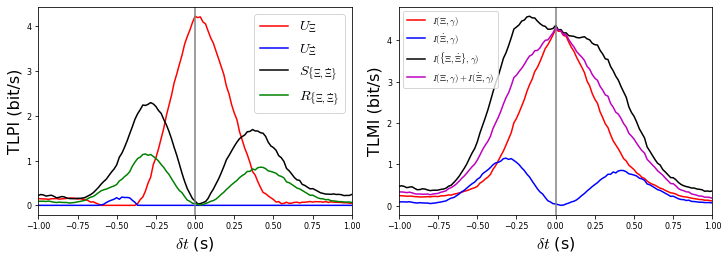

In [27]:
plt.rcParams["font.size"] = 8
i = 1
Information_list = SVDSTKInformation_list.copy()

fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
ax2.plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
ax2.plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
ax2.plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
ax2.plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
# ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_xlabel(r'$\delta t$ (s)', fontsize = 16)
ax2.set_ylabel('TLPI (bit/s)', fontsize = 16)
ax2.legend( (r'$U_\Xi$', r'$U_\dot\Xi$', r'$S_{\{\Xi,\dot\Xi\}}$', r'$R_{\{\Xi,\dot\Xi\}}$'), loc='best', prop={'size': 14})
ax2.axvline(0, c = 'gray')
ax2.set_xlim(window)

ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
ax3.plot(timeshift, Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]
                   +Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
# ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
ax3.set_xlabel(r'$\delta t$ (s)', fontsize = 16)
ax3.set_ylabel('TLMI (bit/s)', fontsize = 16)
ax3.axvline(0, c = 'gray')
ax3.set_xlim(window)
ax3.legend( (r'$I(\Xi,\gamma)$', r'$I(\dot\Xi,\gamma)$', r'$I(\{\Xi,\dot\Xi\},\gamma)$', r'$I(\Xi,\gamma)+I(\dot\Xi,\gamma)$'),
           loc='best', prop={'size': 9})


# fig.tight_layout(pad = 0, w_pad = 0.0, h_pad=0.0)
fig.set_size_inches(10, 3.5)